In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from keras import layers, metrics, optimizers, losses, activations
from keras.applications import MobileNetV2
import matplotlib.pyplot as plt


2023-05-17 23:31:25.608244: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-17 23:31:25.631304: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-17 23:31:26.004287: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2023-05-17 23:31:26.628483: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-17 23:31:26.647103: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-17 23:31:26.647185: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

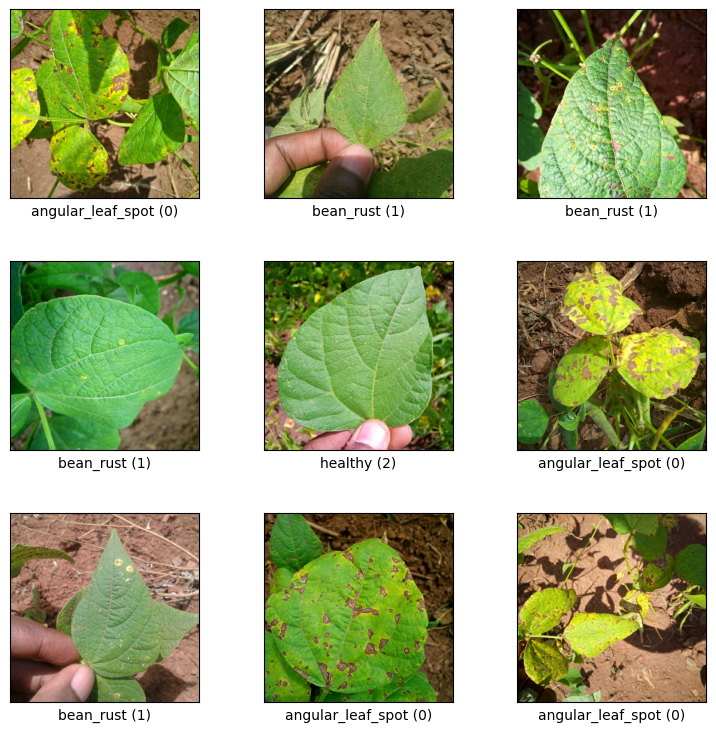

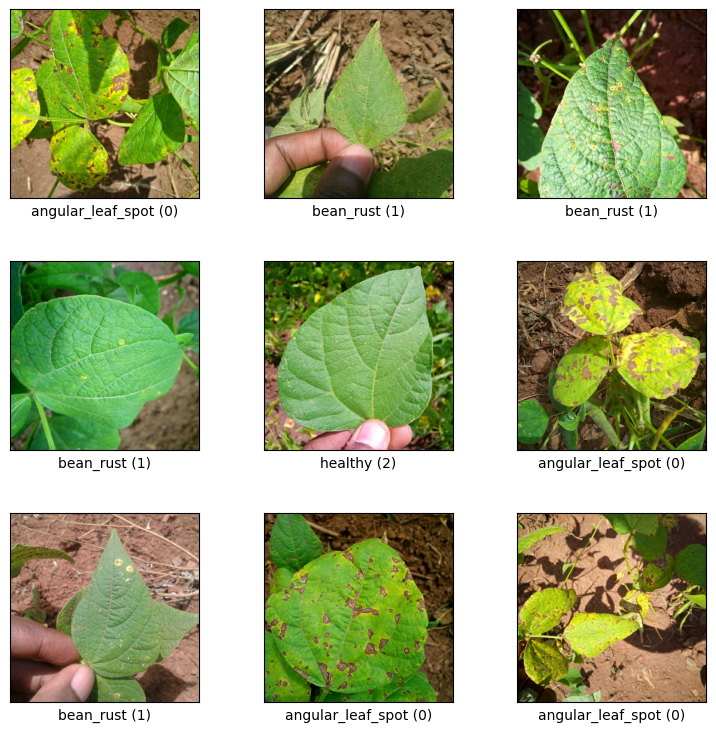

In [2]:
train, train_info = tfds.load(
    name='beans', split='train', shuffle_files=True, with_info=True)
valid, valid_info = tfds.load(
    name='beans', split='validation', shuffle_files=False, with_info=True)
test, test_info = tfds.load(
    name='beans', split='test', shuffle_files=False, with_info=True)
tfds.show_examples(test, test_info)


In [3]:
example_dict = next(iter(train))
print('Image shape', example_dict['image'].shape)
print('Label', example_dict['label'])


Image shape (500, 500, 3)
Label tf.Tensor(1, shape=(), dtype=int64)


2023-05-17 23:31:27.678362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [2]
	 [[{{node Placeholder/_3}}]]
2023-05-17 23:31:27.678661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [2]
	 [[{{node Placeholder/_3}}]]


In [4]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.rot90(
        image, tf.random.uniform(shape=[], minval=0, maxval=20, dtype=tf.int32)
    )

    return image, label

In [5]:
def lower_resolution(images):
    return tf.image.resize(images, [224, 224])

In [6]:
def normalize_img(x):
    return (tf.cast(x['image'], tf.float32)/255.0) - 0.5, x['label']


In [7]:
ds_train = train.map(normalize_img)
ds_train = ds_train.map(augment)
ds_train = ds_train.map(lambda x, y: (lower_resolution(x), y))
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(train_info.splits['train'].num_examples)
ds_train = ds_train.batch(32)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [8]:
ds_valid = valid.map(normalize_img)
ds_valid = ds_valid.map(lambda x, y: (lower_resolution(x), y))
ds_valid = ds_valid.batch(32)
ds_valid = ds_valid.prefetch(tf.data.experimental.AUTOTUNE)

## VGG

In [9]:
model = tf.keras.models.Sequential(
    [
        #rewrite code below without  import



        layers.Conv2D(
            224, 3, activation=activations.relu, input_shape=(224, 224, 3)
        ),
        layers.Conv2D(224, 3, activation=activations.relu),
        layers.MaxPool2D(),
        layers.Conv2D(112, 3, activation=activations.relu),
        layers.Conv2D(112, 3, activation=activations.relu),
        layers.MaxPool2D(),
        layers.Conv2D(56, 3, activation=activations.relu),
        layers.Conv2D(56, 3, activation=activations.relu),
        layers.Conv2D(56, 3, activation=activations.relu),
        layers.MaxPool2D(),
        layers.Conv2D(28, 3, activation=activations.relu),
        layers.Conv2D(28, 3, activation=activations.relu),
        layers.Conv2D(28, 3, activation=activations.relu),
        layers.MaxPool2D(),
        layers.Conv2D(14, 3, activation=activations.relu),
        layers.Conv2D(14, 3, activation=activations.relu),
        layers.Conv2D(14, 3, activation=activations.relu),
        layers.MaxPool2D(),
        layers.Flatten(),
        layers.Dense(16, activation=activations.relu),
        layers.Dense(16, activation=activations.relu),
        layers.Dense(3, activation=activations.softmax),


        
    ]
)
model.summary()
model.compile(
    optimizer=optimizers.Adam(),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 224)     6272      
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 224)     451808    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 224)    0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 112)     225904    
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 112)     113008    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 112)      0         
 2D)                                                    

In [10]:
history = model.fit(ds_train, epochs=30, validation_data=ds_valid)


Epoch 1/30


2023-05-17 23:31:28.158386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [2]
	 [[{{node Placeholder/_3}}]]
2023-05-17 23:31:28.158612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2]
	 [[{{node Placeholder/_0}}]]
2023-05-17 23:31:29.788621: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-05-17 23:31:31.107925: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-17 23:31:3

33/33 [==============================] - ETA: 0s - loss: 1.0706 - sparse_categorical_accuracy: 0.3656

2023-05-17 23:31:52.254887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2023-05-17 23:31:52.255113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]


33/33 [==============================] - 25s 405ms/step - loss: 1.0706 - sparse_categorical_accuracy: 0.3656 - val_loss: 1.0237 - val_sparse_categorical_accuracy: 0.4436
Epoch 2/30
33/33 [==============================] - 10s 292ms/step - loss: 1.0384 - sparse_categorical_accuracy: 0.4255 - val_loss: 0.9779 - val_sparse_categorical_accuracy: 0.4511
Epoch 3/30
33/33 [==============================] - 10s 296ms/step - loss: 0.9866 - sparse_categorical_accuracy: 0.4816 - val_loss: 1.0054 - val_sparse_categorical_accuracy: 0.4962
Epoch 4/30
33/33 [==============================] - 10s 293ms/step - loss: 0.9635 - sparse_categorical_accuracy: 0.5029 - val_loss: 0.9684 - val_sparse_categorical_accuracy: 0.5188
Epoch 5/30
33/33 [==============================] - 9s 281ms/step - loss: 0.9356 - sparse_categorical_accuracy: 0.5503 - val_loss: 0.9335 - val_sparse_categorical_accuracy: 0.5038
Epoch 6/30
33/33 [==============================] - 9s 286ms/step - loss: 0.9500 - sparse_categorical_accur

In [11]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Text(0.5, 1.0, 'Training and Validation Accuracy')

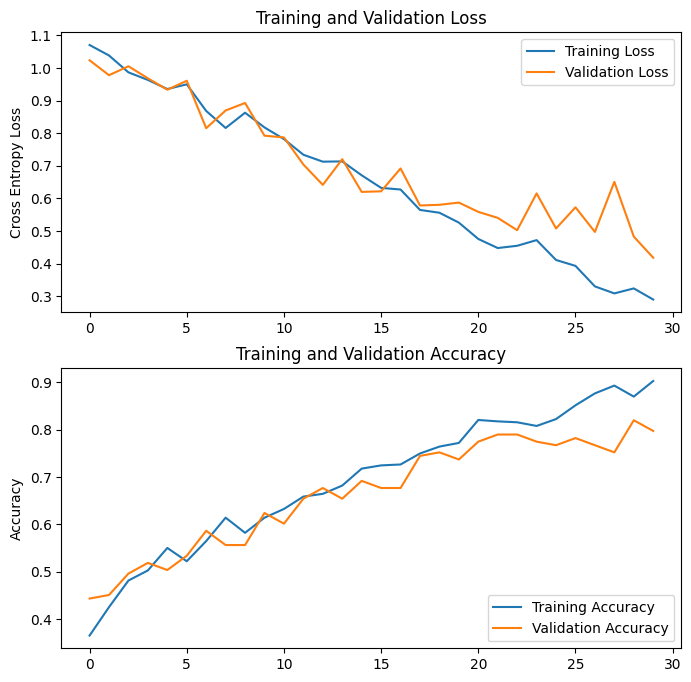

In [12]:
loss_tl = history.history['loss']
val_loss_tl = history.history['val_loss']
acc_tl = history.history['sparse_categorical_accuracy']
val_acc_tl = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(loss_tl, label='Training Loss')
plt.plot(val_loss_tl, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy Loss')
plt.title('Training and Validation Loss')

plt.subplot(2, 1, 2)
plt.plot(acc_tl, label='Training Accuracy')
plt.plot(val_acc_tl, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

1/1 [==============================] - 0s 119ms/step


2023-05-17 23:36:31.128780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-05-17 23:36:31.129004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2023-05-17 23:36:31.242739: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline si

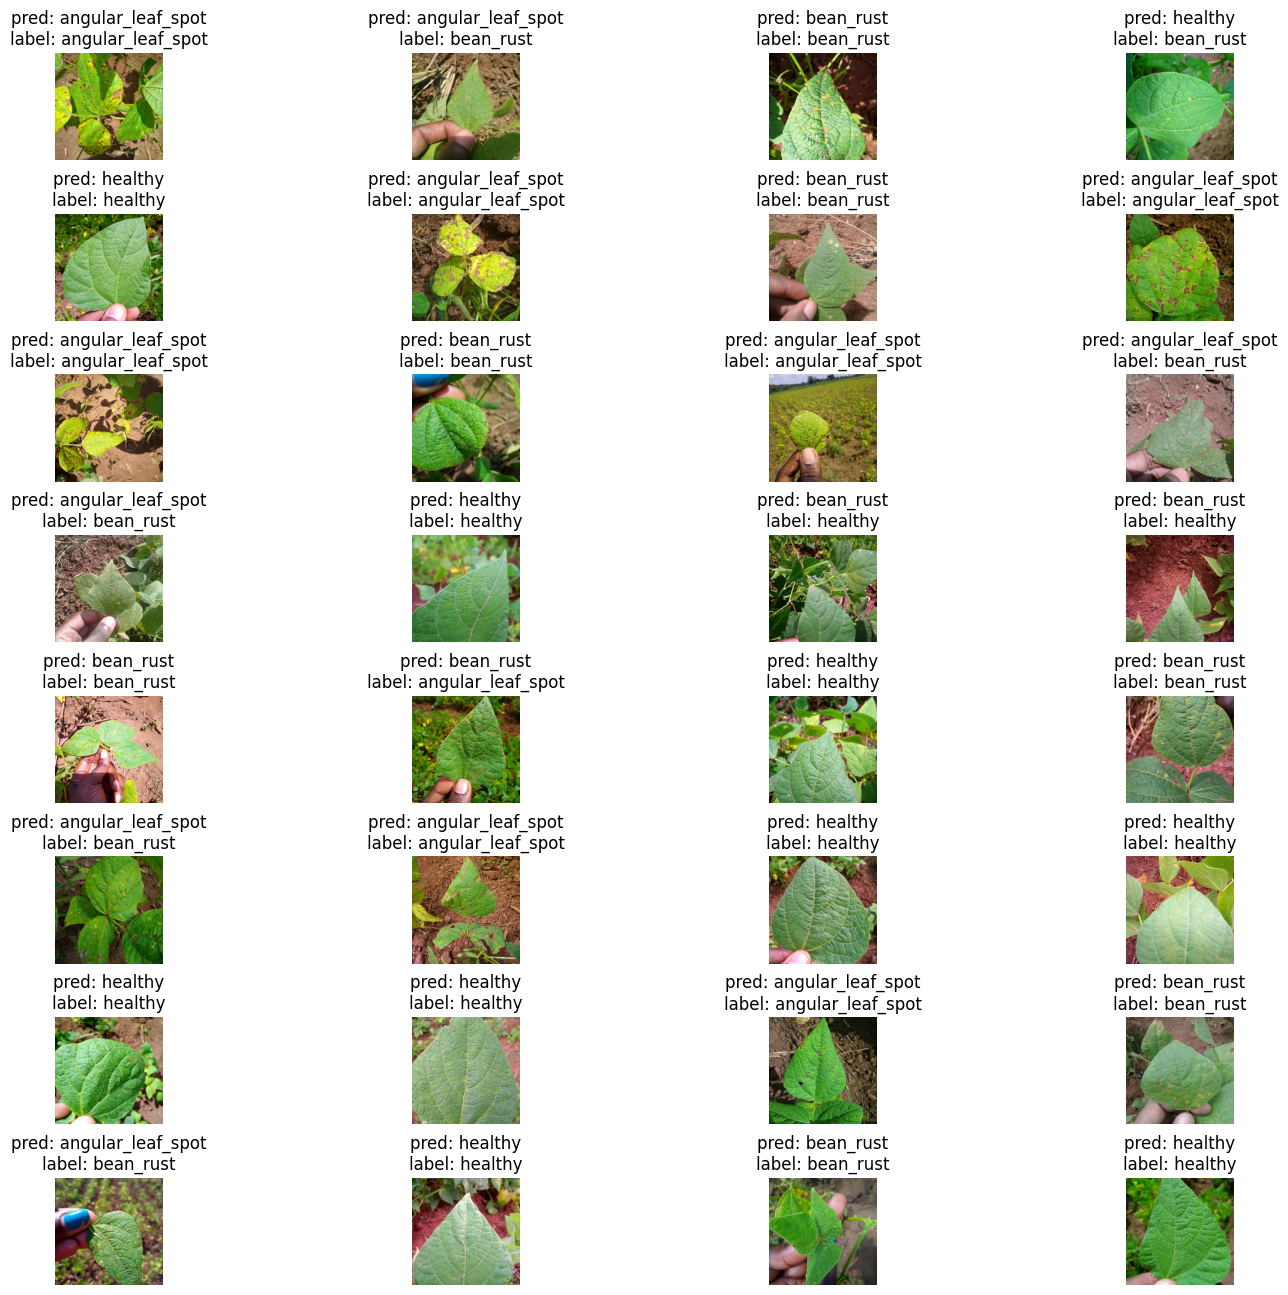

0.71875


In [13]:
ds_test = test.map(normalize_img)
ds_test = ds_test.map(lambda x, y: (lower_resolution(x), y))
ds_test = ds_test.cache()
ds_test = ds_test.batch(32)
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)
ds_test = ds_test.take(1)


labels_names = ['angular_leaf_spot', 'bean_rust', 'healthy']

preds = model.predict(ds_test)
images, labels = next(iter(ds_test))
x = 0
plt.figure(figsize=(18, 16))
for i in range(len(preds)):
    plt.subplot(8, 4, i+1)
    plt.imshow(images[i] + 0.5)
    plt.title('pred: %s\nlabel: %s' % (labels_names[tf.argmax(preds[i])], labels_names[labels[i]]))
    plt.axis('off')
    x += 1 if labels_names[tf.argmax(preds[i])] == labels_names[labels[i]] else 0
plt.subplots_adjust(wspace=0.1, hspace=0.5)
plt.show()
print(x/32)



## Transfer Learning


In [14]:
ds_train = train.map(normalize_img)
ds_train = ds_train.map(augment)
ds_train = ds_train.map(lambda x, y: (lower_resolution(x), y))
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(train_info.splits['train'].num_examples)
ds_train = ds_train.batch(64)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [15]:
ds_valid = valid.map(normalize_img)
ds_valid = ds_valid.map(lambda x, y: (lower_resolution(x), y))
ds_valid = ds_valid.cache()
ds_valid = ds_valid.shuffle(valid_info.splits['validation'].num_examples)
ds_valid = ds_valid.batch(64)
ds_valid = ds_valid.prefetch(tf.data.experimental.AUTOTUNE)

In [16]:
ds_test = test.map(normalize_img)
ds_test = ds_test.map(lambda x, y: (lower_resolution(x), y))
ds_test = ds_test.cache()
ds_test = ds_test.batch(64)
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

#### Fine Tuning

In [54]:
base_model = MobileNetV2(
    weights="imagenet", 
    input_shape=(224, 224, 3),
    include_top=False,
) 

base_model.trainable = True

n = int(0.70 * len(base_model.layers))
for i in range(n):
    base_model.layers[i].trainable = False

In [55]:
model_tl = tf.keras.models.Sequential(
    [
        layers.InputLayer(input_shape=(224, 224, 3)),
        base_model,
        layers.Dropout(0.2),
        layers.Conv2D(256, (3, 3), activation="relu"),
        layers.MaxPool2D(2),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(3, activation="softmax"),
    ]
)

model_tl.summary()

model_tl.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 dropout_27 (Dropout)        (None, 7, 7, 1280)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 5, 5, 256)         2949376   
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 2, 2, 256)        0         
 g2D)                                                            
                                                                 
 dropout_28 (Dropout)        (None, 2, 2, 256)         0         
                                                                 
 flatten_10 (Flatten)        (None, 1024)            

In [56]:
history_tl = model_tl.fit(ds_train, epochs=15, validation_data=ds_valid)

Epoch 1/15


2023-05-17 23:45:32.734142: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_10/dropout_27/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


17/17 [==============================] - 2s 63ms/step - loss: 1.4364 - sparse_categorical_accuracy: 0.5832 - val_loss: 0.6163 - val_sparse_categorical_accuracy: 0.7820
Epoch 2/15
17/17 [==============================] - 1s 46ms/step - loss: 0.3137 - sparse_categorical_accuracy: 0.8820 - val_loss: 0.4039 - val_sparse_categorical_accuracy: 0.8571
Epoch 3/15
17/17 [==============================] - 1s 48ms/step - loss: 0.1518 - sparse_categorical_accuracy: 0.9449 - val_loss: 0.3462 - val_sparse_categorical_accuracy: 0.8722
Epoch 4/15
17/17 [==============================] - 1s 48ms/step - loss: 0.0886 - sparse_categorical_accuracy: 0.9662 - val_loss: 0.4379 - val_sparse_categorical_accuracy: 0.8421
Epoch 5/15
17/17 [==============================] - 1s 47ms/step - loss: 0.0744 - sparse_categorical_accuracy: 0.9768 - val_loss: 0.4243 - val_sparse_categorical_accuracy: 0.8571
Epoch 6/15
17/17 [==============================] - 1s 48ms/step - loss: 0.0535 - sparse_categorical_accuracy: 0.977

Text(0.5, 1.0, 'Training and Validation Accuracy')

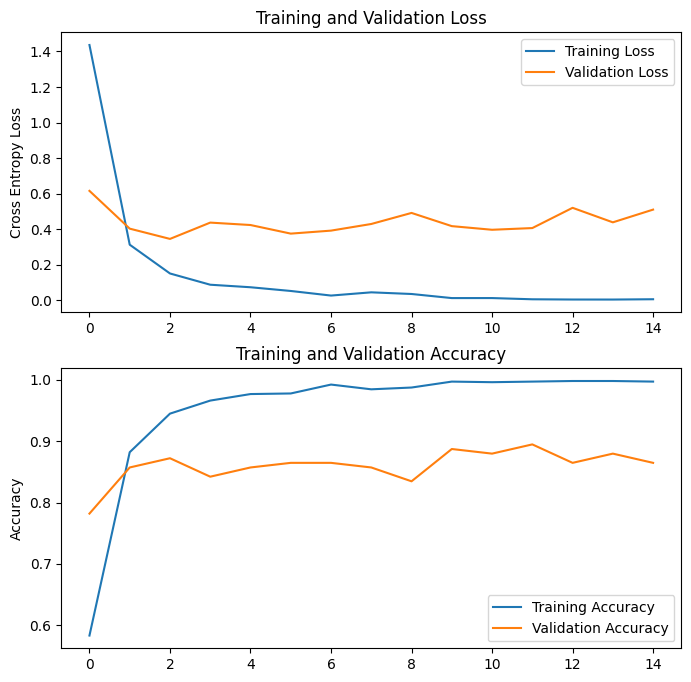

In [57]:
loss_tl = history_tl.history['loss']
val_loss_tl = history_tl.history['val_loss']
acc_tl = history_tl.history['sparse_categorical_accuracy']
val_acc_tl = history_tl.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(loss_tl, label='Training Loss')
plt.plot(val_loss_tl, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy Loss')
plt.title('Training and Validation Loss')

plt.subplot(2, 1, 2)
plt.plot(acc_tl, label='Training Accuracy')
plt.plot(val_acc_tl, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

1/1 [==============================] - 0s 62ms/step


2023-05-17 23:46:04.728421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2023-05-17 23:46:04.728644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-05-17 23:46:04.785844: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline si

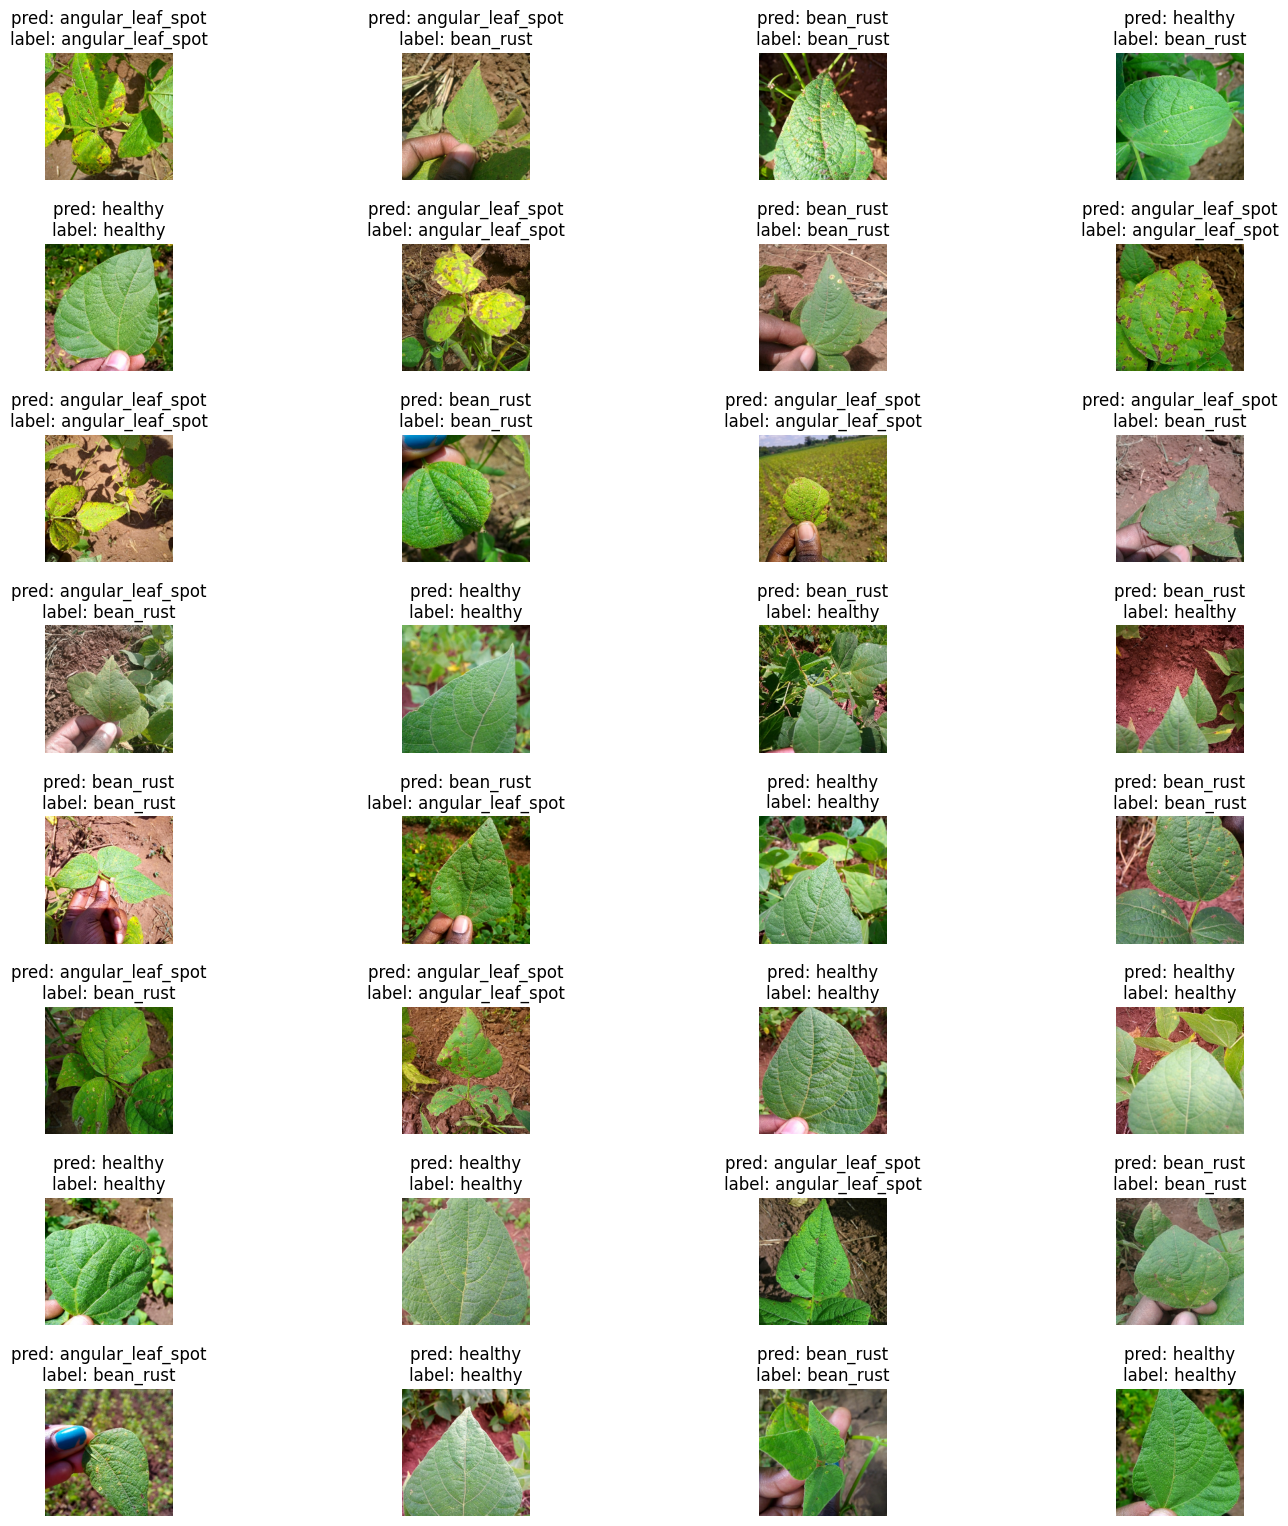

0.71875


In [59]:
ds_test = test.map(normalize_img)
ds_test = ds_test.map(lambda x, y: (lower_resolution(x), y))
ds_test = ds_test.cache()
ds_test = ds_test.batch(32)
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)
ds_test = ds_test.take(1)

labels_names = ['angular_leaf_spot', 'bean_rust', 'healthy']

preds_tl = model_tl.predict(ds_test)
images, labels = next(iter(ds_test))
x = 0
plt.figure(figsize=(18, 19))
for i in range(len(preds)):
    plt.subplot(8, 4, i+1)
    plt.imshow(images[i] + 0.5)
    plt.title('pred: %s\nlabel: %s' % (labels_names[tf.argmax(preds[i])], labels_names[labels[i]]))
    plt.axis('off')
    x += 1 if labels_names[tf.argmax(preds[i])] == labels_names[labels[i]] else 0
plt.subplots_adjust(wspace=0.1, hspace=0.5)
plt.show()

print(x/32)